Non-numeric columns: Index(['Address'], dtype='object')


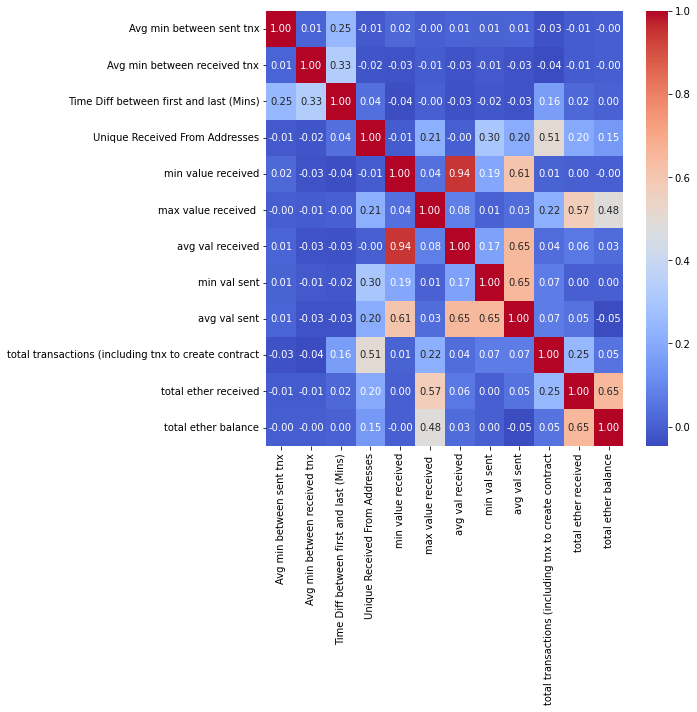

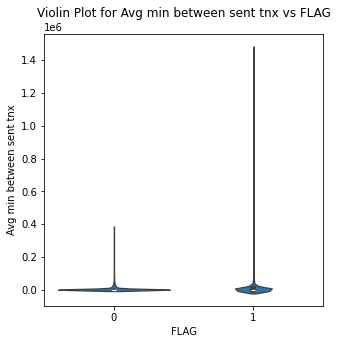

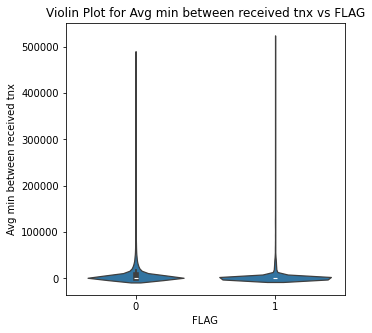

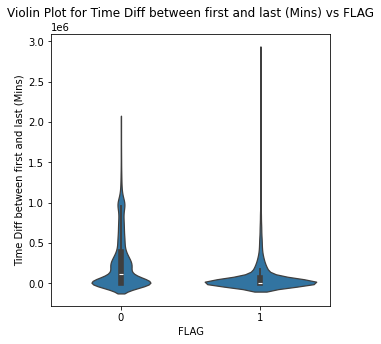

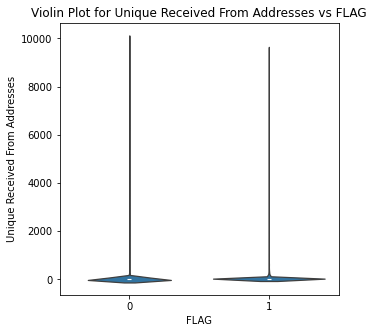

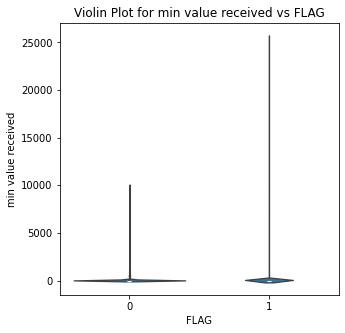

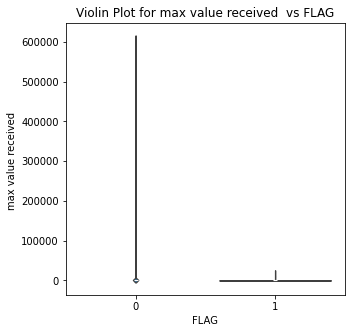

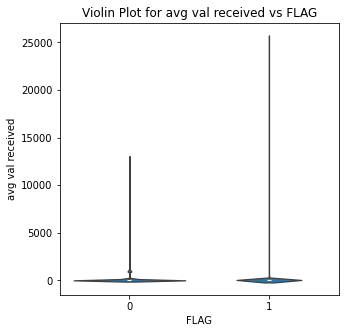

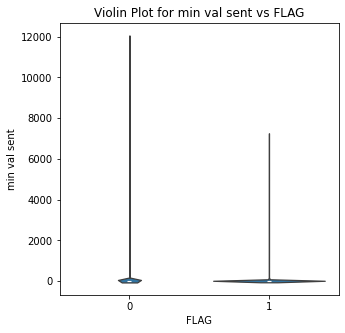

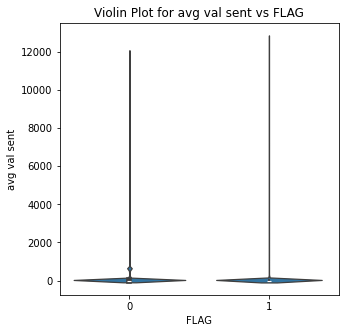

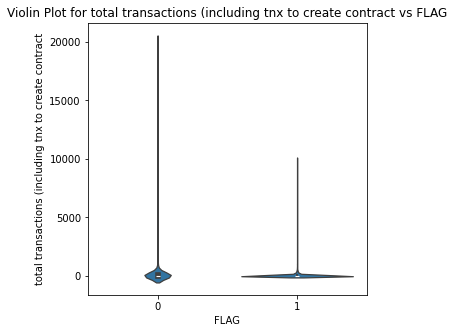

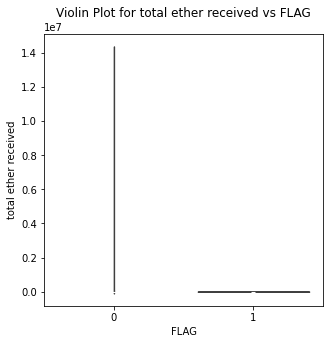

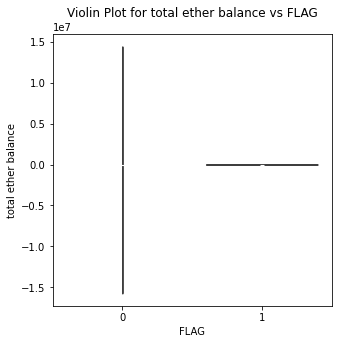

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load train data
train_data = pd.read_csv('q3_data/train_data.csv')

# Check which columns have non-numeric values
non_numeric_cols = train_data.select_dtypes(exclude=[np.number]).columns
print(f"Non-numeric columns: {non_numeric_cols}")

# Option 1: Drop non-numeric columns (if not useful)
train_data = train_data.drop(columns=non_numeric_cols)

# Option 2: Convert hexadecimal values (if useful)
# This is assuming the non-numeric values are hexadecimal strings
# Uncomment the line below if you want to convert hex values
# train_data['column_name'] = train_data['column_name'].apply(lambda x: int(x, 16))

plt.figure(figsize=(8, 8))
corr_mat = pd.DataFrame(train_data.drop('FLAG', axis=1)).corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# Extract features for violin plot
features = [col for col in train_data.columns if col != 'FLAG']
for feature in features:
    plt.figure(figsize=(5, 5))
    sns.violinplot(x='FLAG', y=feature, data=train_data)
    plt.title(f"Violin Plot for {feature} vs FLAG")
    plt.show()

# Preparing data for imputation and scaling
safety_indic_train = train_data['FLAG'].to_numpy()
train_data = train_data.drop(columns=['FLAG'])
train_data = train_data.apply(pd.to_numeric, errors='coerce')  # Ensure all data is numeric
train_data = train_data.replace(0, np.nan)

test_data = pd.read_csv('q3_data/test_data.csv')
safety_indic_test = test_data['FLAG'].to_numpy()
test_data = test_data.drop(columns=['Address','FLAG'])
test_data = test_data.apply(pd.to_numeric, errors='coerce')
test_data = test_data.replace(0, np.nan)

val_data = pd.read_csv('q3_data/val_data.csv')
safety_indic_val = val_data['FLAG'].to_numpy()
val_data = val_data.drop(columns=['Address','FLAG'])
val_data = val_data.apply(pd.to_numeric, errors='coerce')
val_data = val_data.replace(0, np.nan)


imputer = SimpleImputer(strategy='mean')
train_data = imputer.fit_transform(train_data)
test_data = imputer.fit_transform(test_data)
val_data = imputer.fit_transform(val_data)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# scaling
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
# print(train_data)
test_data = scaler.fit_transform(test_data)
val_data = scaler.fit_transform(val_data)



In [5]:
import time
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Decision Tree from scratch
class Node():
    def __init__(self, objects,rows,axis,threshold): # objects is a tuple
        self.objects = objects
        self.rows = rows
        self.left = None
        self.right = None
        self.axis = axis
        self.threshold = threshold



class DecisionTree:
    def __init__(self, max_depth, min_samples, objects, features, criterion,rows):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.cur_depth = 0
        self.root = Node(objects,rows,None,None)
        self.objects = objects
        self.features = features
        self.criterion = criterion

        # iterate over every feature and decide what is the range for each feature
        self.features_threshold_ent = [0] * features.shape[1]
        best_entropy = float('inf')
        for axis in range(features.shape[1]):
            sort_ind = np.argsort(self.features[:, axis])
            left, right = [], [self.root.objects[i] for i in sort_ind]
            right.reverse()

            for i in range(1, len(sort_ind)):
                left.append(right.pop())

                # Calculate entropy for left and right splits
                left_entropy = self._calculate_entropy(left)
                right_entropy = self._calculate_entropy(right)
                weighted_entropy = (len(left) / len(self.root.objects)) * left_entropy + \
                                    (len(right) / len(self.root.objects)) * right_entropy
                
                if weighted_entropy < best_entropy:
                    best_entropy = weighted_entropy
                    self.features_threshold_ent[axis] = features[sort_ind[i], axis] 
        
        # print(self.features_threshold_ent)
        self.features_threshold_gini = [0] * features.shape[1]
        best_gini = float('inf')
        for axis in range(features.shape[1]):
            sort_ind = np.argsort(self.features[:, axis])
            left, right = [], [self.root.objects[i] for i in sort_ind]
            right.reverse()

            for i in range(1, len(sort_ind)):
                left.append(right.pop())

                # Calculate Gini impurity for left and right splits
                left_gini = self._calculate_gini(left)
                right_gini = self._calculate_gini(right)
                weighted_gini = (len(left) / len(self.root.objects)) * left_gini + \
                                (len(right) / len(self.root.objects)) * right_gini
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    self.features_threshold_gini[axis] = features[sort_ind[i]][axis]

    
    def split(self, node, done):
        # Handle entropy or gini calculation
        if self.criterion == 'entropy':
            best_entropy = float('inf')
            best_split = None
            best_split_rows = None
            best_axis = None

            for axis in range(self.features.shape[1]):
                if done[axis]:
                    continue
                
                left_obj = []
                right_obj = []
                left_rows = []
                right_rows = []
                for i in node.rows:
                    if self.features[i][axis] < self.features_threshold_ent[axis]:
                        left_obj.append(self.objects[i])
                    else:
                        right_obj.append(self.objects[i])
                
                # Calculate entropy for left and right splits
                left_entropy = self._calculate_entropy(left_obj)
                right_entropy = self._calculate_entropy(right_obj)
                weighted_entropy = (len(left_obj) / len(node.objects)) * left_entropy + \
                                (len(right_obj) / len(node.objects)) * right_entropy
                
                if weighted_entropy < best_entropy:
                    best_entropy = weighted_entropy
                    best_split = (left_obj, right_obj)
                    best_axis = axis

            for row in node.rows:
                if self.features[row][best_axis] < self.features_threshold_ent[best_axis]:
                    left_rows.append(row)
                else:
                    right_rows.append(row)
            best_split_rows = (left_rows, right_rows)
            return best_split, best_axis, best_split_rows,self.features_threshold_ent[best_axis]

        elif self.criterion == 'gini':
            best_gini = float('inf')
            best_split = None
            best_split_rows = None
            best_axis = None

            for axis in range(self.features.shape[1]):
                if done[axis]:
                    continue
                
                left_obj = []
                right_obj = []
                left_rows = []
                right_rows = []
                for i in node.rows:
                    if self.features[i][axis] < self.features_threshold_gini[axis]:
                        left_obj.append(self.objects[i])
                    else:
                        right_obj.append(self.objects[i])
                
                # Calculate Gini impurity for left and right splits
                left_gini = self._calculate_gini(left_obj)
                right_gini = self._calculate_gini(right_obj)
                weighted_gini = (len(left_obj) / len(node.objects)) * left_gini + \
                                (len(right_obj) / len(node.objects)) * right_gini
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split = (left_obj, right_obj)
                    best_axis = axis

            for row in node.rows:
                if self.features[row][best_axis] < self.features_threshold_gini[best_axis]:
                    left_rows.append(row)
                else:
                    right_rows.append(row)
            best_split_rows = (left_rows, right_rows)
            return best_split, best_axis, best_split_rows,self.features_threshold_gini[best_axis]



    def _calculate_entropy(self, objects):
        # Helper function to calculate entropy
        c = set(objects)
        entropy = 0
        for cls in c:
            prob = sum(objects == cls) / len(objects)
            entropy += prob * np.log2(1 / prob)
        return entropy

    def _calculate_gini(self, objects):
        # Helper function to calculate Gini impurity
        c = set(objects)
        gini = 0
        for cls in c:
            prob = sum(objects == cls) / len(objects)
            gini += prob ** 2
        return 1 - gini

    def build_tree(self, node, cur_depth, done):
        # Check stopping conditions
        # print(cur_depth)
        done = done.copy()
        if cur_depth >= self.max_depth or len(node.objects) <= self.min_samples:
            return
        
        # Mark features as used up in 'done'
        

        # Get the best split for this node
        best_split, best_axis, best_split_rows,threshold = self.split(node, done)
        if best_axis is not None:
            done[best_axis] = True
            node.axis = best_axis
        node.threshold = threshold


        if best_split is None:  # No further split is possible
            return
        
        # Split the node into left and right
        left_objects, right_objects = best_split
        left_rows, right_rows = best_split_rows
        node.left = Node(left_objects, left_rows,None,None)
        node.right = Node(right_objects, right_rows,None,None)
        
        # Recursively build tree for left and right nodes
        self.build_tree(node.left, cur_depth + 1, done)
        self.build_tree(node.right, cur_depth + 1, done)
    
    def predict(self, node, x):
        if node.left is None and node.right is None:
            if len(node.objects) == 0:
                return 0 # default to class 0 if no objects
            return np.argmax(np.bincount(node.objects))
        
        if x[node.axis] < node.threshold:
            return self.predict(node.left, x)
        else:
            return self.predict(node.right, x)

# hyperparameter tuning using validation set
# do for max depth 3 5 8, for each min samples 5 and 50 and do this for both entropy and gini
# also create accuracy plot to visualize performance across different model configurations

max_depths = [3, 5, 8]
min_samples = [5, 50]
criterion = ['entropy', 'gini']
best_accuracy = 0
best_hyperparameters = None

for max_depth in max_depths:
    for min_sample in min_samples:
        for crit in criterion:
            tree = DecisionTree(max_depth, min_sample, safety_indic_train, train_data, crit, rows=range(len(safety_indic_train)))
            done = [False] * train_data.shape[0]
            tree.build_tree(tree.root, 0, done)

            # Predict on validation set
            val_pres_custom = [tree.predict(tree.root, x) for x in val_data]
            val_accuracy_custom = accuracy_score(safety_indic_val, val_pres_custom)

            if val_accuracy_custom > best_accuracy:
                best_accuracy = val_accuracy_custom
                best_hyperparameters = (max_depth, min_sample, crit)
            
            print(f"Max Depth: {max_depth}, Min Samples: {min_sample}, Criterion: {crit}, Validation Accuracy: {val_accuracy_custom}")




Max Depth: 3, Min Samples: 5, Criterion: entropy, Validation Accuracy: 0.6044150110375276
Max Depth: 3, Min Samples: 5, Criterion: gini, Validation Accuracy: 0.6101545253863134
Max Depth: 3, Min Samples: 50, Criterion: entropy, Validation Accuracy: 0.6044150110375276
Max Depth: 3, Min Samples: 50, Criterion: gini, Validation Accuracy: 0.6101545253863134
Max Depth: 5, Min Samples: 5, Criterion: entropy, Validation Accuracy: 0.6172185430463576
Max Depth: 5, Min Samples: 5, Criterion: gini, Validation Accuracy: 0.6565121412803532
Max Depth: 5, Min Samples: 50, Criterion: entropy, Validation Accuracy: 0.6172185430463576
Max Depth: 5, Min Samples: 50, Criterion: gini, Validation Accuracy: 0.6565121412803532
Max Depth: 8, Min Samples: 5, Criterion: entropy, Validation Accuracy: 0.5969094922737307
Max Depth: 8, Min Samples: 5, Criterion: gini, Validation Accuracy: 0.6163355408388521
Max Depth: 8, Min Samples: 50, Criterion: entropy, Validation Accuracy: 0.5969094922737307
Max Depth: 8, Min Sa

Custom Tree - Train Accuracy: 0.8105751186665194, Validation Accuracy: 0.6565121412803532, Test Accuracy: 0.47686329918756626
Custom Tree - Computation Time: 449.20496010780334 seconds
Scikit-learn Tree - Train Accuracy: 0.9996688376200463, Validation Accuracy: 0.6428256070640177, Test Accuracy: 0.622394913458142
Scikit-learn Tree - Computation Time: 0.0737297534942627 seconds


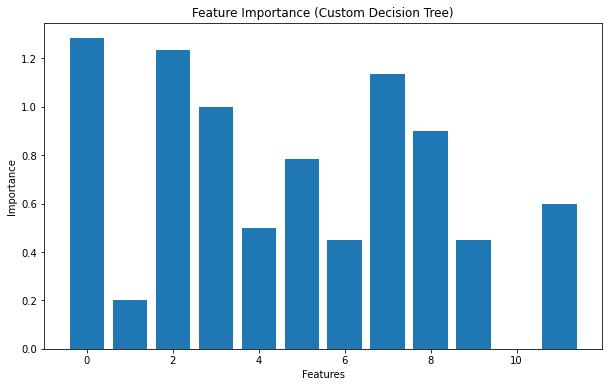

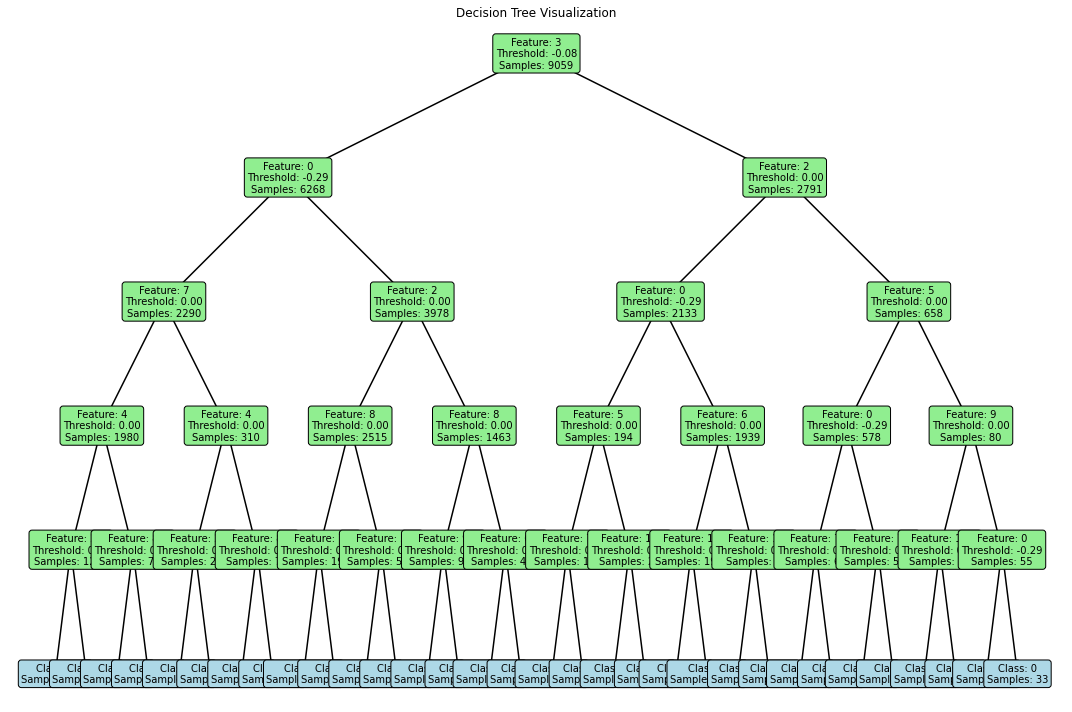

In [6]:
#usage
start_time_custom = time.time()
# Train the custom decision tree
tree = DecisionTree(max_depth=5, min_samples=5, objects=safety_indic_train, features=train_data, criterion='gini', rows=range(len(safety_indic_train)))
done = [False] * len(train_data[0])
tree.build_tree(tree.root, 0, done)
end_time_custom = time.time()

# Custom Decision Tree Predictions
train_preds_custom = [tree.predict(tree.root, x) for x in train_data]
val_preds_custom = [tree.predict(tree.root, x) for x in val_data]
test_preds_custom = [tree.predict(tree.root, x) for x in test_data]

# Compute accuracies for custom decision tree
train_accuracy_custom = accuracy_score(safety_indic_train, train_preds_custom)
val_accuracy_custom = accuracy_score(safety_indic_val, val_preds_custom)
test_accuracy_custom = accuracy_score(safety_indic_test, test_preds_custom)

print(f"Custom Tree - Train Accuracy: {train_accuracy_custom}, Validation Accuracy: {val_accuracy_custom}, Test Accuracy: {test_accuracy_custom}")
print(f"Custom Tree - Computation Time: {end_time_custom - start_time_custom} seconds")


# Timing the Scikit-learn decision tree implementation
start_time_sklearn = time.time()
# Train the Scikit-learn decision tree
sklearn_tree = DecisionTreeClassifier()
sklearn_tree.fit(train_data, safety_indic_train)
end_time_sklearn = time.time()

# Scikit-learn Decision Tree Predictions
train_preds_sklearn = sklearn_tree.predict(train_data)
val_preds_sklearn = sklearn_tree.predict(val_data)
test_preds_sklearn = sklearn_tree.predict(test_data)

# Compute accuracies for Scikit-learn decision tree
train_accuracy_sklearn = accuracy_score(safety_indic_train, train_preds_sklearn)
val_accuracy_sklearn = accuracy_score(safety_indic_val, val_preds_sklearn)
test_accuracy_sklearn = accuracy_score(safety_indic_test, test_preds_sklearn)

print(f"Scikit-learn Tree - Train Accuracy: {train_accuracy_sklearn}, Validation Accuracy: {val_accuracy_sklearn}, Test Accuracy: {test_accuracy_sklearn}")
print(f"Scikit-learn Tree - Computation Time: {end_time_sklearn - start_time_sklearn} seconds")

# Here we are calculating feature importance based on the number of times
# a feature is used for splitting in the decision tree

def calculate_feature_importance(tree):
    feature_importance = np.zeros(tree.features.shape[1])

    def traverse(node, depth):
        if node.left is not None and node.right is not None:
            # Give more importance to features that appear closer to the root (shallow depth)
            feature_importance[node.axis] += 1 / (depth + 1)  # Weight by depth, adding 1 to avoid division by zero
            
            # Recursively traverse left and right subtrees, incrementing the depth
            traverse(node.left, depth + 1)
            traverse(node.right, depth + 1)

    traverse(tree.root, 0)  # Start at depth 0 for the root node
    return feature_importance


# Calculate feature importance for the custom decision tree
importance = calculate_feature_importance(tree)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Custom Decision Tree)")
plt.show()

# visulise the custom tree

def visualize_tree(tree, figsize=(15, 10)):
    def get_tree_depth(node):
        if node.left is None and node.right is None:
            return 0
        left_depth = get_tree_depth(node.left) if node.left else 0
        right_depth = get_tree_depth(node.right) if node.right else 0
        return max(left_depth, right_depth) + 1
    
    def get_tree_width(node):
        if node is None:
            return 0
        if node.left is None and node.right is None:
            return 1
        return get_tree_width(node.left) + get_tree_width(node.right)
    
    def plot_node(node, x, y, dx, dy, ax):
        if node is None:
            return
            
        # Create node text
        if node.left is None and node.right is None:
            # Leaf node
            if len(node.objects) == 0:
                predicted_class = 0
            else:
                predicted_class = np.argmax(np.bincount(node.objects))
            node_text = f'Class: {predicted_class}\nSamples: {len(node.objects)}'
            box_color = 'lightblue'
        else:
            # Decision node
            node_text = f'Feature: {node.axis}\nThreshold: {node.threshold:.2f}\nSamples: {len(node.objects)}'
            box_color = 'lightgreen'
        
        # Draw the node
        bbox = dict(facecolor=box_color, edgecolor='black', boxstyle='round')
        ax.text(x, y, node_text, ha='center', va='center', bbox=bbox)
        
        # Draw connections to children
        if node.left:
            left_x = x - dx
            left_y = y - dy
            ax.plot([x, left_x], [y, left_y], 'k-')
            plot_node(node.left, left_x, left_y, dx/2, dy, ax)
            
        if node.right:
            right_x = x + dx
            right_y = y - dy
            ax.plot([x, right_x], [y, right_y], 'k-')
            plot_node(node.right, right_x, right_y, dx/2, dy, ax)
    
    # Create figure
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_axis_off()
    
    # Calculate initial positions
    depth = get_tree_depth(tree.root)
    width = get_tree_width(tree.root)
    
    # Plot the tree
    plot_node(tree.root, 0.5, 0.9, 0.2, 0.2, ax)
    
    plt.title('Decision Tree Visualization')
    plt.tight_layout()
    plt.show()

# Usage example:
visualize_tree(tree)

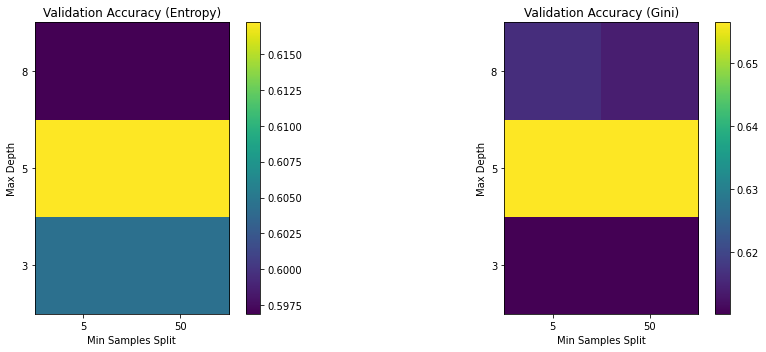

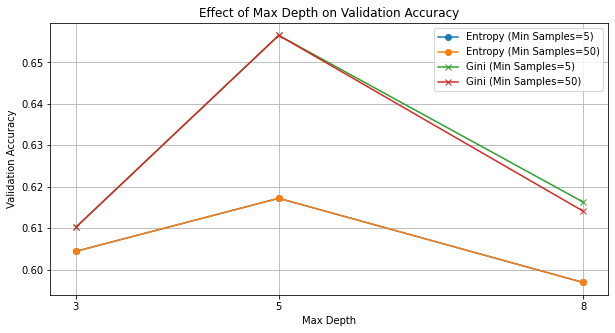

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
max_depths = [3, 3, 3, 3, 5, 5, 5, 5, 8, 8, 8, 8]
min_samples = [5, 5, 50, 50, 5, 5, 50, 50, 5, 5, 50, 50]
criteria = ['entropy', 'gini', 'entropy', 'gini', 'entropy', 'gini', 'entropy', 'gini', 'entropy', 'gini', 'entropy', 'gini']
accuracies = [0.6044, 0.6102, 0.6044, 0.6102, 0.6172, 0.6565, 0.6172, 0.6565, 0.5969, 0.6163, 0.5969, 0.6141]  # Rounded for clarity

# Reshape data for plotting
max_depths_unique = sorted(list(set(max_depths)))
min_samples_unique = sorted(list(set(min_samples)))

accuracy_matrix_entropy = np.zeros((len(max_depths_unique), len(min_samples_unique)))
accuracy_matrix_gini = np.zeros((len(max_depths_unique), len(min_samples_unique)))

for i, depth in enumerate(max_depths_unique):
    for j, samples in enumerate(min_samples_unique):
        for k in range(len(max_depths)):
            if max_depths[k] == depth and min_samples[k] == samples:
                if criteria[k] == 'entropy':
                    accuracy_matrix_entropy[i, j] = accuracies[k]
                elif criteria[k] == 'gini':
                    accuracy_matrix_gini[i, j] = accuracies[k]


# Create plots

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Entropy Plot
im_entropy = axes[0].imshow(accuracy_matrix_entropy, cmap='viridis', origin='lower')
axes[0].set_xticks(np.arange(len(min_samples_unique)))
axes[0].set_xticklabels(min_samples_unique)
axes[0].set_yticks(np.arange(len(max_depths_unique)))
axes[0].set_yticklabels(max_depths_unique)
axes[0].set_xlabel('Min Samples Split')
axes[0].set_ylabel('Max Depth')
axes[0].set_title('Validation Accuracy (Entropy)')
fig.colorbar(im_entropy, ax=axes[0], fraction=0.046, pad=0.03)


# Gini Plot
im_gini = axes[1].imshow(accuracy_matrix_gini, cmap='viridis', origin='lower')
axes[1].set_xticks(np.arange(len(min_samples_unique)))
axes[1].set_xticklabels(min_samples_unique)
axes[1].set_yticks(np.arange(len(max_depths_unique)))
axes[1].set_yticklabels(max_depths_unique)
axes[1].set_xlabel('Min Samples Split')
axes[1].set_ylabel('Max Depth')
axes[1].set_title('Validation Accuracy (Gini)')
fig.colorbar(im_gini, ax=axes[1], fraction=0.046, pad=0.03)

plt.tight_layout()
plt.show()



#Additional plot: Line plot to show the effect of max_depth

plt.figure(figsize=(10, 5))

# Plot for entropy
plt.plot(max_depths_unique, accuracy_matrix_entropy[:, 0], marker='o', label='Entropy (Min Samples=5)')
plt.plot(max_depths_unique, accuracy_matrix_entropy[:, 1], marker='o', label='Entropy (Min Samples=50)')

# Plot for gini
plt.plot(max_depths_unique, accuracy_matrix_gini[:, 0], marker='x', label='Gini (Min Samples=5)')
plt.plot(max_depths_unique, accuracy_matrix_gini[:, 1], marker='x', label='Gini (Min Samples=50)')

plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Max Depth on Validation Accuracy')
plt.xticks(max_depths_unique)  # Set x-axis ticks to the unique max depth values
plt.legend()
plt.grid(True)
plt.show()